In [1]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2025-07-11 23:56:30.414631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752278190.601962      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752278190.653056      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Use GPU Facilities.

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda - Tesla T4


In [4]:
indian_df = pd.read_csv('/kaggle/input/crema-d-dataset/crema_df.csv')

In [5]:
indian_df = indian_df[(indian_df["emotion"]=="neutral") | (indian_df["emotion"]=="happy") | (indian_df["emotion"]=="sad") | (indian_df["emotion"]=="angry")]

In [6]:
train_df = indian_df.sample(frac=0.8)
test_df = indian_df.drop(train_df.index)

In [8]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(f"/kaggle/input/cremad/{example['path']}", sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/3920 [00:00<?, ? examples/s]

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [12]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {
            'neutral': 0,
            'happy': 1,
            'sad': 2,
            'angry': 3,
            'fear': 4,
            'disgust': 5
        }
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["emotion"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["emotion"]))


In [13]:
#import torch.nn as nn
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
#model.classifier = nn.Linear(model.classifier.in_features, 6)
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [14]:
# Check unique labels in the training and test data
print(set(train_data["emotion"]))
print(set(test_data["emotion"]))

{'happy', 'sad', 'neutral', 'angry'}
{'happy', 'sad', 'neutral', 'angry'}


In [15]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [16]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 10

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/10


100%|██████████| 1960/1960 [15:20<00:00,  2.13it/s, Loss=1.222, Accuracy=0.596]


Epoch 2/10


100%|██████████| 1960/1960 [15:22<00:00,  2.12it/s, Loss=0.130, Accuracy=0.740]


Epoch 3/10


100%|██████████| 1960/1960 [15:21<00:00,  2.13it/s, Loss=0.011, Accuracy=0.784]


Epoch 4/10


100%|██████████| 1960/1960 [15:20<00:00,  2.13it/s, Loss=1.375, Accuracy=0.806]


Epoch 5/10


100%|██████████| 1960/1960 [15:22<00:00,  2.12it/s, Loss=0.017, Accuracy=0.834]


Epoch 6/10


100%|██████████| 1960/1960 [15:20<00:00,  2.13it/s, Loss=0.164, Accuracy=0.844]


Epoch 7/10


100%|██████████| 1960/1960 [15:24<00:00,  2.12it/s, Loss=0.001, Accuracy=0.855]


Epoch 8/10


100%|██████████| 1960/1960 [15:19<00:00,  2.13it/s, Loss=0.217, Accuracy=0.879]


Epoch 9/10


100%|██████████| 1960/1960 [15:21<00:00,  2.13it/s, Loss=0.054, Accuracy=0.880]


Epoch 10/10


100%|██████████| 1960/1960 [15:19<00:00,  2.13it/s, Loss=0.268, Accuracy=0.895]


In [19]:
torch.save(model.state_dict(), '/kaggle/working/model_final_epoch.pth')

In [18]:
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([2, 80080])
attention_mask shape: torch.Size([2, 80080])
labels shape: torch.Size([2])


Visualise the training loss and accuracy.

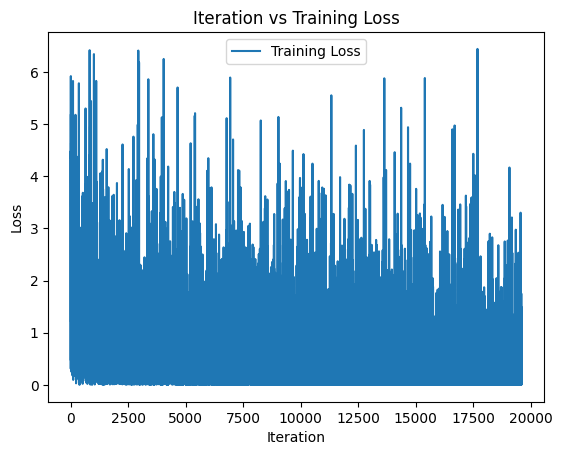

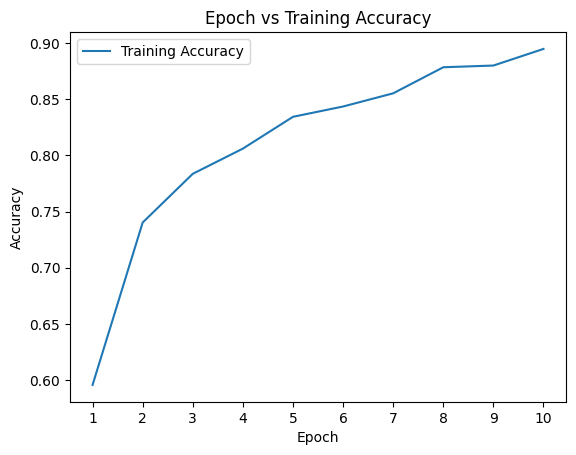

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

Test the model.

In [25]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 980/980 [01:13<00:00, 13.31it/s, loss=0.137, accuracy=0.850] 


The final accuracy on the test dataset: 85.0%
